In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Base path and labels
base_path = '/content/data/'
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Constants
IMAGE_SIZE = 64
BATCH_SIZE = 16
VERBOSE = 1

In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/drive/My Drive/majordata1.zip'

# Define the path to extract the files
extract_dir = '/content/data/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [ ]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
x_train=[]
y_train=[]

# Loading Training Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
for i in class_names:

    folderPath = os.path.join(os.path.join(base_path, 'Testing'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|████████████████████████████| 1457/1457 [00:02<00:00, 613.07it/s]


Training dataset Loading complete.


100%|██████████████████████████████| 300/300 [00:00<00:00, 885.63it/s]


Testing dataset Loading complete.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit the encoder and transform the labels into integers
y_train = label_encoder.fit_transform(y_train)

# Now `y_train` will contain integer labels instead of strings
print(set(y_train))  # Should output {0} since there is only one class


{0, 1, 2, 3}


In [ ]:
x_train_50, x_test_50, y_train_50, y_test_50 = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

x_train_40, x_test_40, y_train_40, y_test_40 = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

x_train_20, x_test_20, y_train_20, y_test_20 = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print("Shapes of all train-test splits:")
print(f"x_train_50: {x_train_50.shape}, x_test_50: {x_test_50.shape}")
print(f"x_train_40: {x_train_40.shape}, x_test_40: {x_test_40.shape}")
print(f"x_train_30: {x_train_30.shape}, x_test_30: {x_test_30.shape}")
print(f"x_train_20: {x_train_20.shape}, x_test_20: {x_test_20.shape}")
print(f"x_train_10: {x_train_10.shape}, x_test_10: {x_test_10.shape}")


Shapes of all train-test splits:
x_train_50: (3511, 64, 64, 3), x_test_50: (3512, 64, 64, 3)
x_train_40: (4213, 64, 64, 3), x_test_40: (2810, 64, 64, 3)
x_train_30: (4916, 64, 64, 3), x_test_30: (2107, 64, 64, 3)
x_train_20: (5618, 64, 64, 3), x_test_20: (1405, 64, 64, 3)
x_train_10: (6320, 64, 64, 3), x_test_10: (703, 64, 64, 3)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Define image size and flatten the image data
IMG_SIZE = 64
num_classes = 4

# Flatten the data to 1D vectors and normalize pixel values
def prepare_data(x_train, x_test):
    # Reshape the data
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # Normalize the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)
    return x_train_scaled, x_test_scaled

# Train logistic regression on each split
splits = {
    '50': (x_train_50, x_test_50, y_train_50, y_test_50),
    '40': (x_train_40, x_test_40, y_train_40, y_test_40),
    '30': (x_train_30, x_test_30, y_train_30, y_test_30),
    '20': (x_train_20, x_test_20, y_train_20, y_test_20),
    '10': (x_train_10, x_test_10, y_train_10, y_test_10),
}

models = {}

for split_name, (x_train, x_test, y_train, y_test) in splits.items():
    print(f"\nTraining logistic regression model on split with test size {split_name}%...")

    # Prepare the data
    x_train_scaled, x_test_scaled = prepare_data(x_train, x_test)

    # Create and train logistic regression model
    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(x_train_scaled, y_train)

    # Save the trained model
    models[f'logistic_model_{split_name}'] = model



Training logistic regression model on split with test size 50%...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training logistic regression model on split with test size 40%...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training logistic regression model on split with test size 30%...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training logistic regression model on split with test size 20%...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training logistic regression model on split with test size 10%...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Evaluating logistic regression model on split with test size 50%...
Metrics for split 50%:
  Accuracy: 0.8519
  AUC: 0.9529
  AUPR: 0.8802
  Balanced Accuracy: 0.8452
  Precision: 0.8435
  Recall: 0.8452
  F1 Score: 0.8439
  Confusion Matrix:
[[638 120  11   4]
 [134 570  58  64]
 [ 17  36 944  18]
 [ 20  34   4 840]]


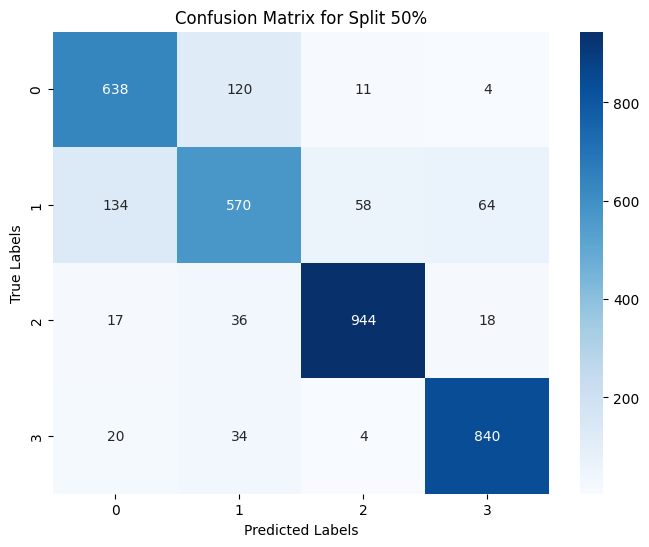


Evaluating logistic regression model on split with test size 40%...
Metrics for split 40%:
  Accuracy: 0.8626
  AUC: 0.9571
  AUPR: 0.8936
  Balanced Accuracy: 0.8568
  Precision: 0.8551
  Recall: 0.8568
  F1 Score: 0.8552
  Confusion Matrix:
[[512  83  11   2]
 [103 474  47  46]
 [ 13  23 757  16]
 [ 17  23   2 681]]


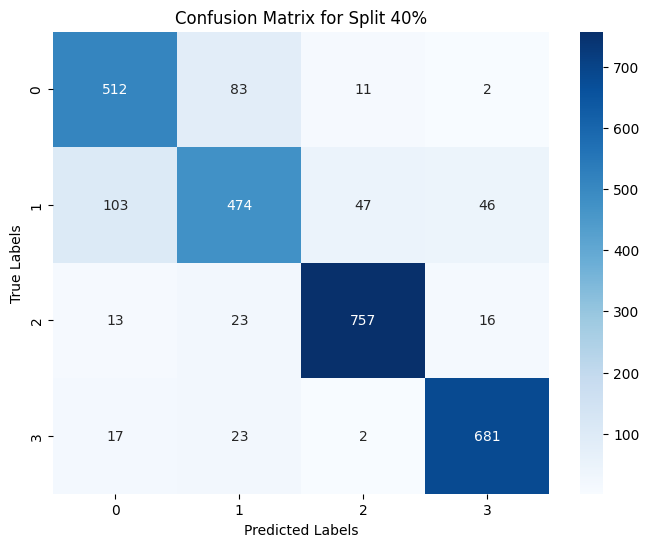


Evaluating logistic regression model on split with test size 30%...
Metrics for split 30%:
  Accuracy: 0.8714
  AUC: 0.9600
  AUPR: 0.9005
  Balanced Accuracy: 0.8665
  Precision: 0.8639
  Recall: 0.8665
  F1 Score: 0.8643
  Confusion Matrix:
[[372  56   7   0]
 [ 78 376  28  32]
 [ 11  18 574  10]
 [ 14  15   2 514]]


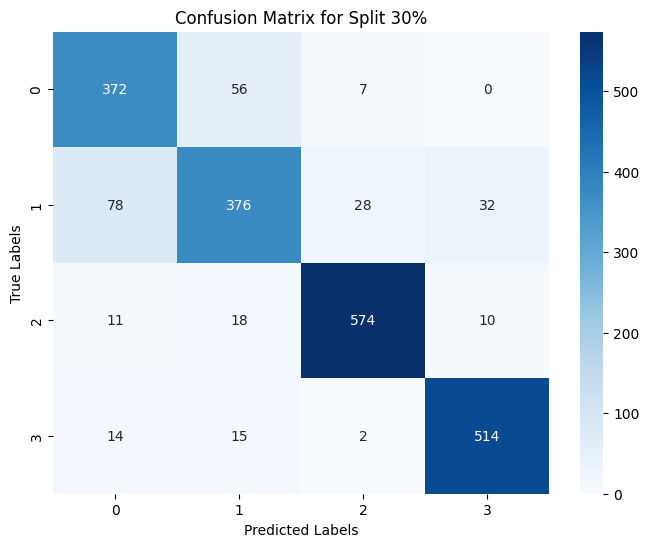


Evaluating logistic regression model on split with test size 20%...
Metrics for split 20%:
  Accuracy: 0.8804
  AUC: 0.9651
  AUPR: 0.9149
  Balanced Accuracy: 0.8744
  Precision: 0.8712
  Recall: 0.8744
  F1 Score: 0.8719
  Confusion Matrix:
[[240  36   2   0]
 [ 53 252  17  18]
 [  7   9 389   6]
 [  7  13   0 356]]


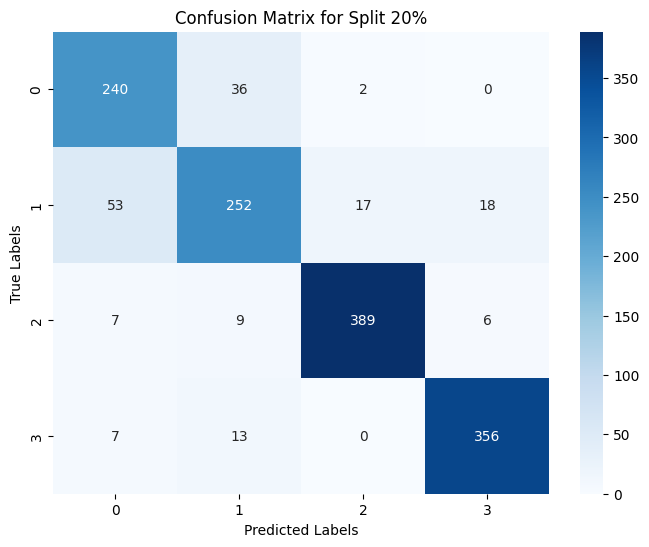


Evaluating logistic regression model on split with test size 10%...
Metrics for split 10%:
  Accuracy: 0.8819
  AUC: 0.9633
  AUPR: 0.9085
  Balanced Accuracy: 0.8782
  Precision: 0.8749
  Recall: 0.8782
  F1 Score: 0.8751
  Confusion Matrix:
[[124  19   1   0]
 [ 31 130   8   9]
 [  2   2 186   3]
 [  3   5   0 180]]


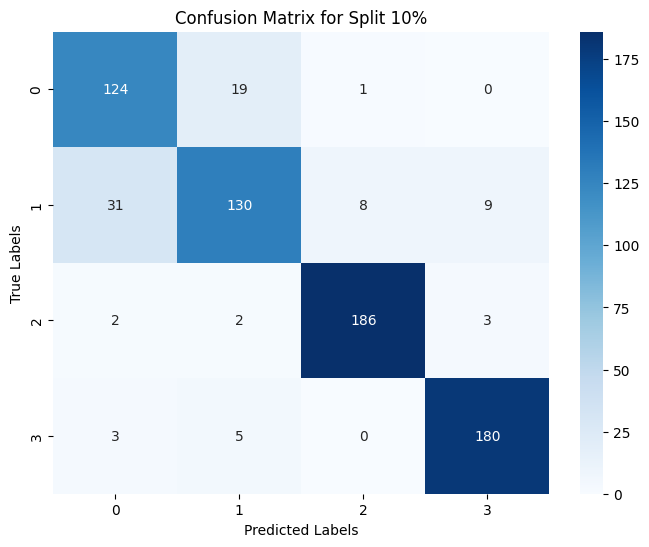

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import numpy as np

# Dictionary to store evaluation metrics for each split
metrics = {}

# Evaluate each trained model
for split_name, (x_train, x_test, y_train, y_test) in splits.items():
    print(f"\nEvaluating logistic regression model on split with test size {split_name}%...")

    # Prepare the data
    x_train_scaled, x_test_scaled = prepare_data(x_train, x_test)

    # Get the trained model
    model = models[f'logistic_model_{split_name}']

    # Predict probabilities and labels
    y_pred = model.predict(x_test_scaled)
    y_pred_proba = model.predict_proba(x_test_scaled)  # Probability scores for AUC/AUPR

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest AUC
    aupr = average_precision_score(y_test, y_pred_proba, average='macro')  # Macro-AUPR
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Store the metrics and confusion matrix
    metrics[split_name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'AUPR': aupr,
        'Balanced Accuracy': bal_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

    # Print metrics for the split
    print(f"Metrics for split {split_name}%:")
    for metric_name, metric_value in metrics[split_name].items():
        if metric_name == 'Confusion Matrix':
            print(f"  {metric_name}:\n{metric_value}")
        else:
            print(f"  {metric_name}: {metric_value:.4f}")

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for Split {split_name}%")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Save the image
    plt.savefig(f"confusion_matrix_split_{split_name}.png")
    plt.show()
